# Skenario 1: Fine-Tuning (Perbandingan BERT, RoBERTa, IndoBERTweet)

Notebook ini menjalankan skenario pertama dari penelitian transfer learning: **standard fine-tuning**.

**Tujuan:**
- Melatih tiga model pretrained (BERT Multilingual, RoBERTa, dan IndoBERTweet) pada dataset klasifikasi sentimen.
- Membandingkan performa mereka berdasarkan metrik standar (Loss, Accuracy, Precision, Recall, F1-Score).
- Visualisasikan riwayat training dan validasi untuk setiap metrik dalam plot perbandingan.

# Import Libraries

In [1]:
%%capture
%pip install --upgrade ipywidgets
%pip install --upgrade jupyter

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.optim import AdamW  

from transformers import (
    AutoTokenizer, 
    AutoConfig, 
    AutoModelForSequenceClassification, 
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import logging
import seaborn as sns
import warnings
import time
import gc

logging.set_verbosity_error()
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted")
plt.style.use('default')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {DEVICE}")

MODEL_CONFIGS = {
    "IndoBERTbase": "indobenchmark/indobert-base-p1",
    "IndoBERTweet": "indolem/indobertweet-base-uncased",
    "RoBERTa": "databoks-irfan/twitter-comment-roberta-base-indonesian-smsa"
}

# Hyperparameters
RANDOM_STATE = 42
MAX_LEN = 128
BATCH_SIZE = 16
N_SPLITS = 3
EPOCHS = 4
LEARNING_RATES_TO_TEST = [5e-5, 3e-5, 2e-5, 1e-5]
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.2

DATA_PATH = '../data/bbm_data_preprocesed.csv' 

Menggunakan perangkat: cuda


In [ ]:
class SentimentDataset(Dataset):
    """Dataset class untuk sentimen."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx]); label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
def load_data(path):
    """Memuat data dari CSV dan mengembalikan teks dan label."""
    df = pd.read_csv(path)
    label_map = {"neutral": 0, "positive": 1, "negative": 2}
    df['label'] = df['sentiment'].map(label_map)
    df.dropna(subset=['label'], inplace=True)
    df['label'] = df['label'].astype(int)

    print(f"Data berhasil dimuat. Total sampel: {len(df)}")
    return df['text'].tolist(), df['label'].tolist(), len(label_map)

all_texts, all_labels, num_labels = load_data(DATA_PATH)

Data berhasil dimuat. Total sampel: 5755


In [6]:
def compute_metrics(labels, preds):
    """Menghitung metrik evaluasi."""
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

In [7]:
def average_histories(histories):
    """Merata-ratakan riwayat dari beberapa fold."""
    if not histories:
        return {}
    
    avg_history = {}
    # Ambil semua key dari histori pertama (asumsi semua sama)
    metric_keys = histories[0].keys()
    # Dapatkan jumlah epoch maksimum dari semua fold
    max_epochs = max(len(h['train_loss']) for h in histories)

    for key in metric_keys:
        # Kumpulkan nilai metrik dari semua fold, pad dengan NaN jika epoch lebih sedikit
        padded_values = [h[key] + [np.nan] * (max_epochs - len(h[key])) for h in histories]
        avg_history[key] = np.nanmean(padded_values, axis=0)
        
    return avg_history

In [8]:
def train_epoch(model, data_loader, optimizer, device, scaler, scheduler):
    """Satu epoch training."""
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with autocast(device_type=device.type, dtype=torch.float16):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics

def evaluate_epoch(model, data_loader, device):
    """Satu epoch evaluasi."""
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    
    progress_bar = tqdm(data_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics

In [ ]:
def run_kfold_training_for_lr(model_name_hf, texts, labels, num_labels, lr, n_splits, epochs, batch_size, max_len, weight_decay, dropout_rate, device):
    """Menjalankan K-Fold CV untuk satu model dengan satu LR dan format logging baru."""
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
    full_dataset = SentimentDataset(texts, labels, tokenizer, max_len)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(full_dataset)), y=labels)):
        print(f"\nMemulai Fold {fold + 1} dari {n_splits}")
        
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size * 2)

        config = AutoConfig.from_pretrained(model_name_hf, num_labels=num_labels, classifier_dropout=dropout_rate)
        model = AutoModelForSequenceClassification.from_pretrained(model_name_hf, config=config).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scaler = GradScaler()
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)
        
        single_fold_history = {
            'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []
        }
        
        final_val_metrics_for_fold = {}
        final_val_loss_for_fold = 0

        for epoch in range(epochs):
            # Kita tidak perlu menampilkan log per epoch, cukup jalankan training & evaluasi
            train_epoch(model, train_loader, optimizer, device, scaler, scheduler)
            val_loss, val_metrics = evaluate_epoch(model, val_loader, device)
            
            # Simpan metrik untuk sejarah dan untuk laporan akhir fold
            single_fold_history['train_loss'].append(val_loss) 
            single_fold_history['train_f1'].append(val_metrics['f1']) 
            single_fold_history['val_loss'].append(val_loss)
            single_fold_history['val_f1'].append(val_metrics['f1'])
            
            final_val_metrics_for_fold = val_metrics
            final_val_loss_for_fold = val_loss
        
        print(f"Hasil Akhir Fold {fold + 1}:")
        print(f"  Validation Loss: {final_val_loss_for_fold:.4f}")
        print(f"  Validation Accuracy: {final_val_metrics_for_fold['accuracy']:.4f}")
        print(f"  Validation Precision: {final_val_metrics_for_fold['precision']:.4f}")
        print(f"  Validation Recall: {final_val_metrics_for_fold['recall']:.4f}")
        print(f"  Validation F1-Score: {final_val_metrics_for_fold['f1']:.4f}")

        fold_histories.append(single_fold_history)
        
        del model, optimizer, scaler, scheduler
        gc.collect()
        torch.cuda.empty_cache()

    avg_history = average_histories(fold_histories)
    final_avg_val_f1 = avg_history['val_f1'][-1]
    
    return final_avg_val_f1, avg_history

In [13]:
all_results = {}
all_histories = {}

# Loop utama untuk setiap model
for model_alias, model_name_hf in MODEL_CONFIGS.items():
    print(f"Model: {model_alias}")
    
    model_lr_results = {}
    model_lr_histories = {}
    
    # Loop untuk setiap learning rate
    for lr in LEARNING_RATES_TO_TEST:
        print(f"\nMenguji Learning Rate: {lr}")
        
        avg_f1, avg_history = run_kfold_training_for_lr(
            model_name_hf=model_name_hf,
            texts=all_texts,
            labels=all_labels,
            num_labels=num_labels,
            lr=lr,
            n_splits=N_SPLITS,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            max_len=MAX_LEN,
            weight_decay=WEIGHT_DECAY,
            dropout_rate=DROPOUT_RATE,
            device=DEVICE
        )
        
        print(f"\nRingkasan untuk LR {lr}: Rata-rata F1 Validasi Akhir ({N_SPLITS}-Fold) adalah {avg_f1:.4f}")
        
        model_lr_results[lr] = avg_f1
        model_lr_histories[lr] = avg_history
        
    all_results[model_alias] = model_lr_results
    all_histories[model_alias] = model_lr_histories

print("\n\nLaporan Akhir: Pencarian Learning Rate Terbaik")

for model_alias, lr_results in all_results.items():
    best_lr = max(lr_results, key=lr_results.get)
    best_f1 = lr_results[best_lr]
    print(f"\nModel: {model_alias}")
    print(f"  Learning Rate Terbaik (Sweet Spot) adalah {best_lr} dengan rata-rata F1-Score {best_f1:.4f}")
    for lr, f1 in sorted(lr_results.items()):
        print(f"    - LR: {lr}, Rata-rata F1: {f1:.4f}")

Model: IndoBERTbase

Menguji Learning Rate: 5e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2710
  Validation Accuracy: 0.9182
  Validation Precision: 0.9182
  Validation Recall: 0.9182
  Validation F1-Score: 0.9182

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.2985
  Validation Accuracy: 0.9114
  Validation Precision: 0.9122
  Validation Recall: 0.9114
  Validation F1-Score: 0.9115

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2612
  Validation Accuracy: 0.9249
  Validation Precision: 0.9251
  Validation Recall: 0.9249
  Validation F1-Score: 0.9248

Ringkasan untuk LR 5e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9182

Menguji Learning Rate: 3e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2329
  Validation Accuracy: 0.9177
  Validation Precision: 0.9187
  Validation Recall: 0.9177
  Validation F1-Score: 0.9178

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.2479
  Validation Accuracy: 0.9114
  Validation Precision: 0.9117
  Validation Recall: 0.9114
  Validation F1-Score: 0.9113

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2328
  Validation Accuracy: 0.9181
  Validation Precision: 0.9179
  Validation Recall: 0.9181
  Validation F1-Score: 0.9178

Ringkasan untuk LR 3e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9156

Menguji Learning Rate: 2e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2499
  Validation Accuracy: 0.9119
  Validation Precision: 0.9129
  Validation Recall: 0.9119
  Validation F1-Score: 0.9110

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.2507
  Validation Accuracy: 0.9098
  Validation Precision: 0.9101
  Validation Recall: 0.9098
  Validation F1-Score: 0.9096

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2329
  Validation Accuracy: 0.9140
  Validation Precision: 0.9153
  Validation Recall: 0.9140
  Validation F1-Score: 0.9134

Ringkasan untuk LR 2e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9113

Menguji Learning Rate: 1e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2716
  Validation Accuracy: 0.9020
  Validation Precision: 0.9044
  Validation Recall: 0.9020
  Validation F1-Score: 0.9005

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.2714
  Validation Accuracy: 0.8994
  Validation Precision: 0.9022
  Validation Recall: 0.8994
  Validation F1-Score: 0.8982

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2796
  Validation Accuracy: 0.8994
  Validation Precision: 0.9027
  Validation Recall: 0.8994
  Validation F1-Score: 0.8983

Ringkasan untuk LR 1e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.8990
Model: IndoBERTweet

Menguji Learning Rate: 5e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.5197
  Validation Accuracy: 0.9239
  Validation Precision: 0.9241
  Validation Recall: 0.9239
  Validation F1-Score: 0.9240

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.5948
  Validation Accuracy: 0.9124
  Validation Precision: 0.9131
  Validation Recall: 0.9124
  Validation F1-Score: 0.9126

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.5702
  Validation Accuracy: 0.9244
  Validation Precision: 0.9261
  Validation Recall: 0.9244
  Validation F1-Score: 0.9245

Ringkasan untuk LR 5e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9204

Menguji Learning Rate: 3e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.3620
  Validation Accuracy: 0.9291
  Validation Precision: 0.9301
  Validation Recall: 0.9291
  Validation F1-Score: 0.9294

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

c:\rifqimaruf\kp\venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.4319
  Validation Accuracy: 0.9124
  Validation Precision: 0.9143
  Validation Recall: 0.9124
  Validation F1-Score: 0.9126

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.4389
  Validation Accuracy: 0.9234
  Validation Precision: 0.9246
  Validation Recall: 0.9234
  Validation F1-Score: 0.9235

Ringkasan untuk LR 3e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9218

Menguji Learning Rate: 2e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.3078
  Validation Accuracy: 0.9229
  Validation Precision: 0.9236
  Validation Recall: 0.9229
  Validation F1-Score: 0.9230

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.3291
  Validation Accuracy: 0.9114
  Validation Precision: 0.9139
  Validation Recall: 0.9114
  Validation F1-Score: 0.9118

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2656
  Validation Accuracy: 0.9208
  Validation Precision: 0.9211
  Validation Recall: 0.9208
  Validation F1-Score: 0.9208

Ringkasan untuk LR 2e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9185

Menguji Learning Rate: 1e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

c:\rifqimaruf\kp\venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2214
  Validation Accuracy: 0.9234
  Validation Precision: 0.9241
  Validation Recall: 0.9234
  Validation F1-Score: 0.9233

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

c:\rifqimaruf\kp\venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.2587
  Validation Accuracy: 0.9077
  Validation Precision: 0.9084
  Validation Recall: 0.9077
  Validation F1-Score: 0.9077

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2547
  Validation Accuracy: 0.9124
  Validation Precision: 0.9140
  Validation Recall: 0.9124
  Validation F1-Score: 0.9123

Ringkasan untuk LR 1e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9144
Model: RoBERTa

Menguji Learning Rate: 5e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.3503
  Validation Accuracy: 0.9052
  Validation Precision: 0.9060
  Validation Recall: 0.9052
  Validation F1-Score: 0.9051

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

c:\rifqimaruf\kp\venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.3244
  Validation Accuracy: 0.9108
  Validation Precision: 0.9107
  Validation Recall: 0.9108
  Validation F1-Score: 0.9108

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.3259
  Validation Accuracy: 0.9114
  Validation Precision: 0.9118
  Validation Recall: 0.9114
  Validation F1-Score: 0.9112

Ringkasan untuk LR 5e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9090

Menguji Learning Rate: 3e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2887
  Validation Accuracy: 0.9067
  Validation Precision: 0.9068
  Validation Recall: 0.9067
  Validation F1-Score: 0.9066

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.2924
  Validation Accuracy: 0.9051
  Validation Precision: 0.9047
  Validation Recall: 0.9051
  Validation F1-Score: 0.9048

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2753
  Validation Accuracy: 0.9119
  Validation Precision: 0.9124
  Validation Recall: 0.9119
  Validation F1-Score: 0.9110

Ringkasan untuk LR 3e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9075

Menguji Learning Rate: 2e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.2925
  Validation Accuracy: 0.9072
  Validation Precision: 0.9071
  Validation Recall: 0.9072
  Validation F1-Score: 0.9071

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.3313
  Validation Accuracy: 0.8973
  Validation Precision: 0.8975
  Validation Recall: 0.8973
  Validation F1-Score: 0.8974

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.2636
  Validation Accuracy: 0.9129
  Validation Precision: 0.9131
  Validation Recall: 0.9129
  Validation F1-Score: 0.9125

Ringkasan untuk LR 2e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.9057

Menguji Learning Rate: 1e-05

Memulai Fold 1 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 1:
  Validation Loss: 0.4590
  Validation Accuracy: 0.8411
  Validation Precision: 0.8394
  Validation Recall: 0.8411
  Validation F1-Score: 0.8390

Memulai Fold 2 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 2:
  Validation Loss: 0.3180
  Validation Accuracy: 0.8884
  Validation Precision: 0.8883
  Validation Recall: 0.8884
  Validation F1-Score: 0.8876

Memulai Fold 3 dari 3


Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/240 [00:00<?, ?it/s]

Validating:   0%|          | 0/60 [00:00<?, ?it/s]

Hasil Akhir Fold 3:
  Validation Loss: 0.3181
  Validation Accuracy: 0.8869
  Validation Precision: 0.8887
  Validation Recall: 0.8869
  Validation F1-Score: 0.8841

Ringkasan untuk LR 1e-05: Rata-rata F1 Validasi Akhir (3-Fold) adalah 0.8702


Laporan Akhir: Pencarian Learning Rate Terbaik

Model: IndoBERTbase
  Learning Rate Terbaik (Sweet Spot) adalah 5e-05 dengan rata-rata F1-Score 0.9182
    - LR: 1e-05, Rata-rata F1: 0.8990
    - LR: 2e-05, Rata-rata F1: 0.9113
    - LR: 3e-05, Rata-rata F1: 0.9156
    - LR: 5e-05, Rata-rata F1: 0.9182

Model: IndoBERTweet
  Learning Rate Terbaik (Sweet Spot) adalah 3e-05 dengan rata-rata F1-Score 0.9218
    - LR: 1e-05, Rata-rata F1: 0.9144
    - LR: 2e-05, Rata-rata F1: 0.9185
    - LR: 3e-05, Rata-rata F1: 0.9218
    - LR: 5e-05, Rata-rata F1: 0.9204

Model: RoBERTa
  Learning Rate Terbaik (Sweet Spot) adalah 5e-05 dengan rata-rata F1-Score 0.9090
    - LR: 1e-05, Rata-rata F1: 0.8702
    - LR: 2e-05, Rata-rata F1: 0.9057
    - LR: 3e-05, Rata

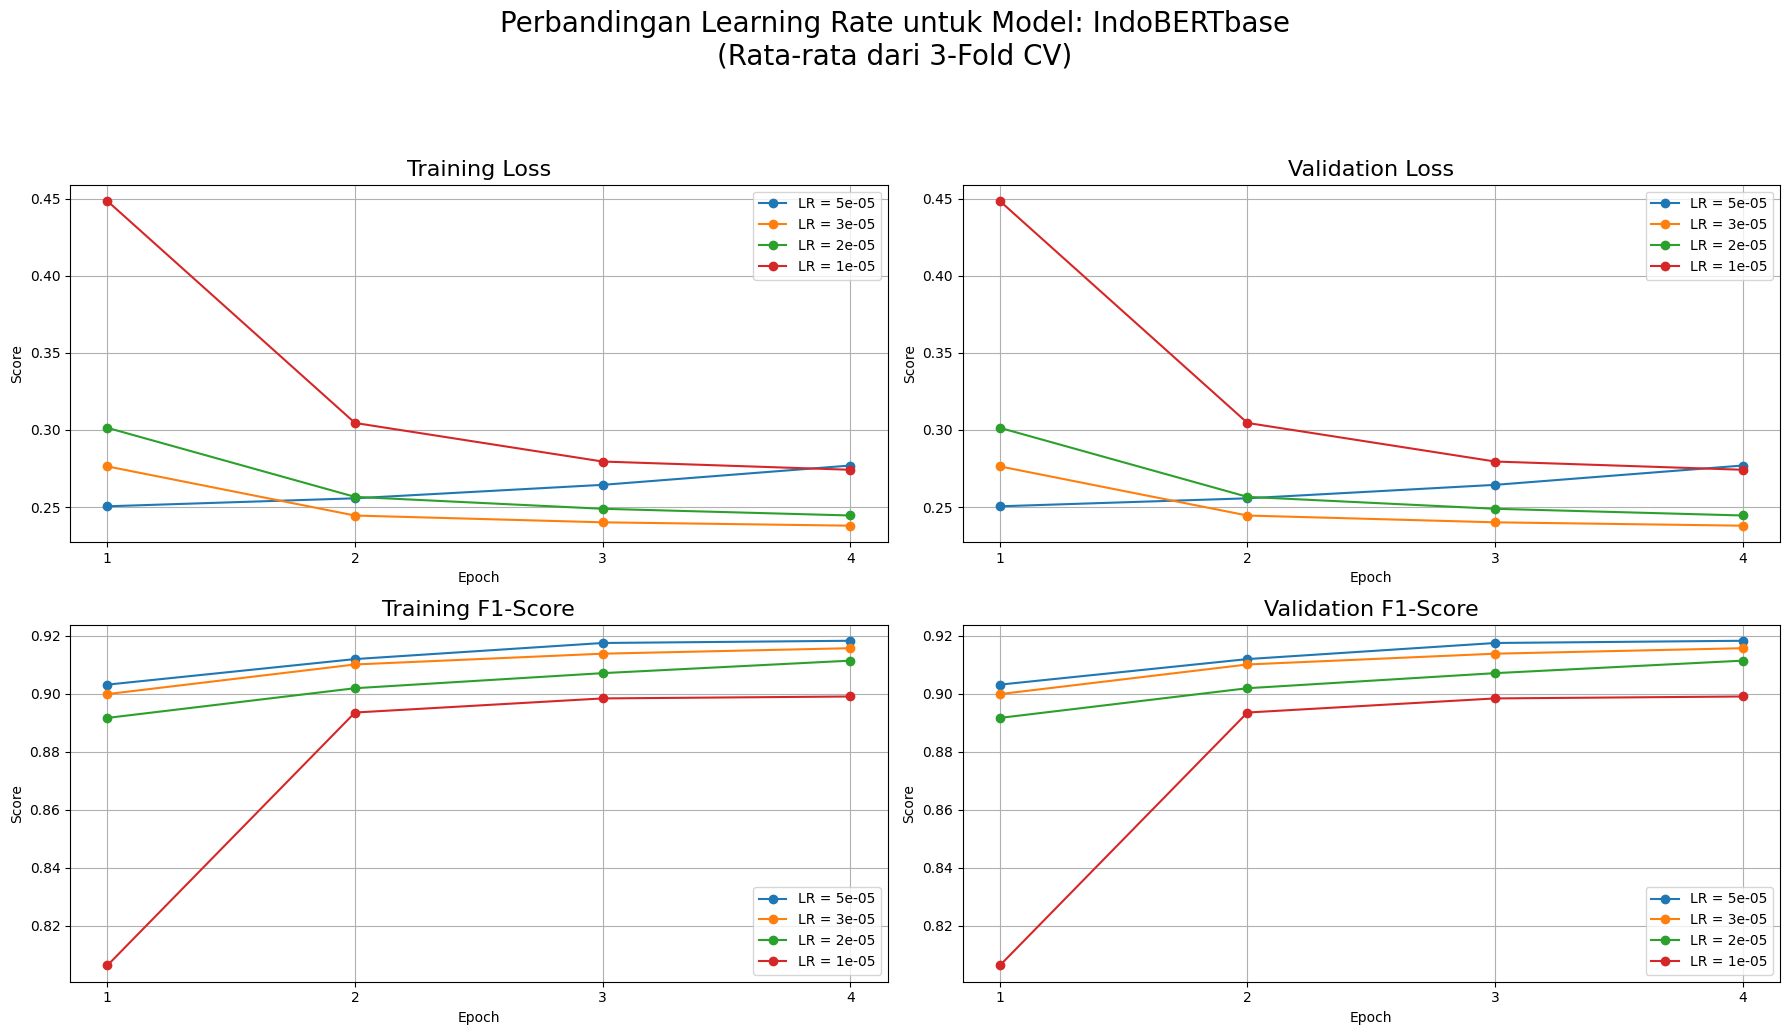

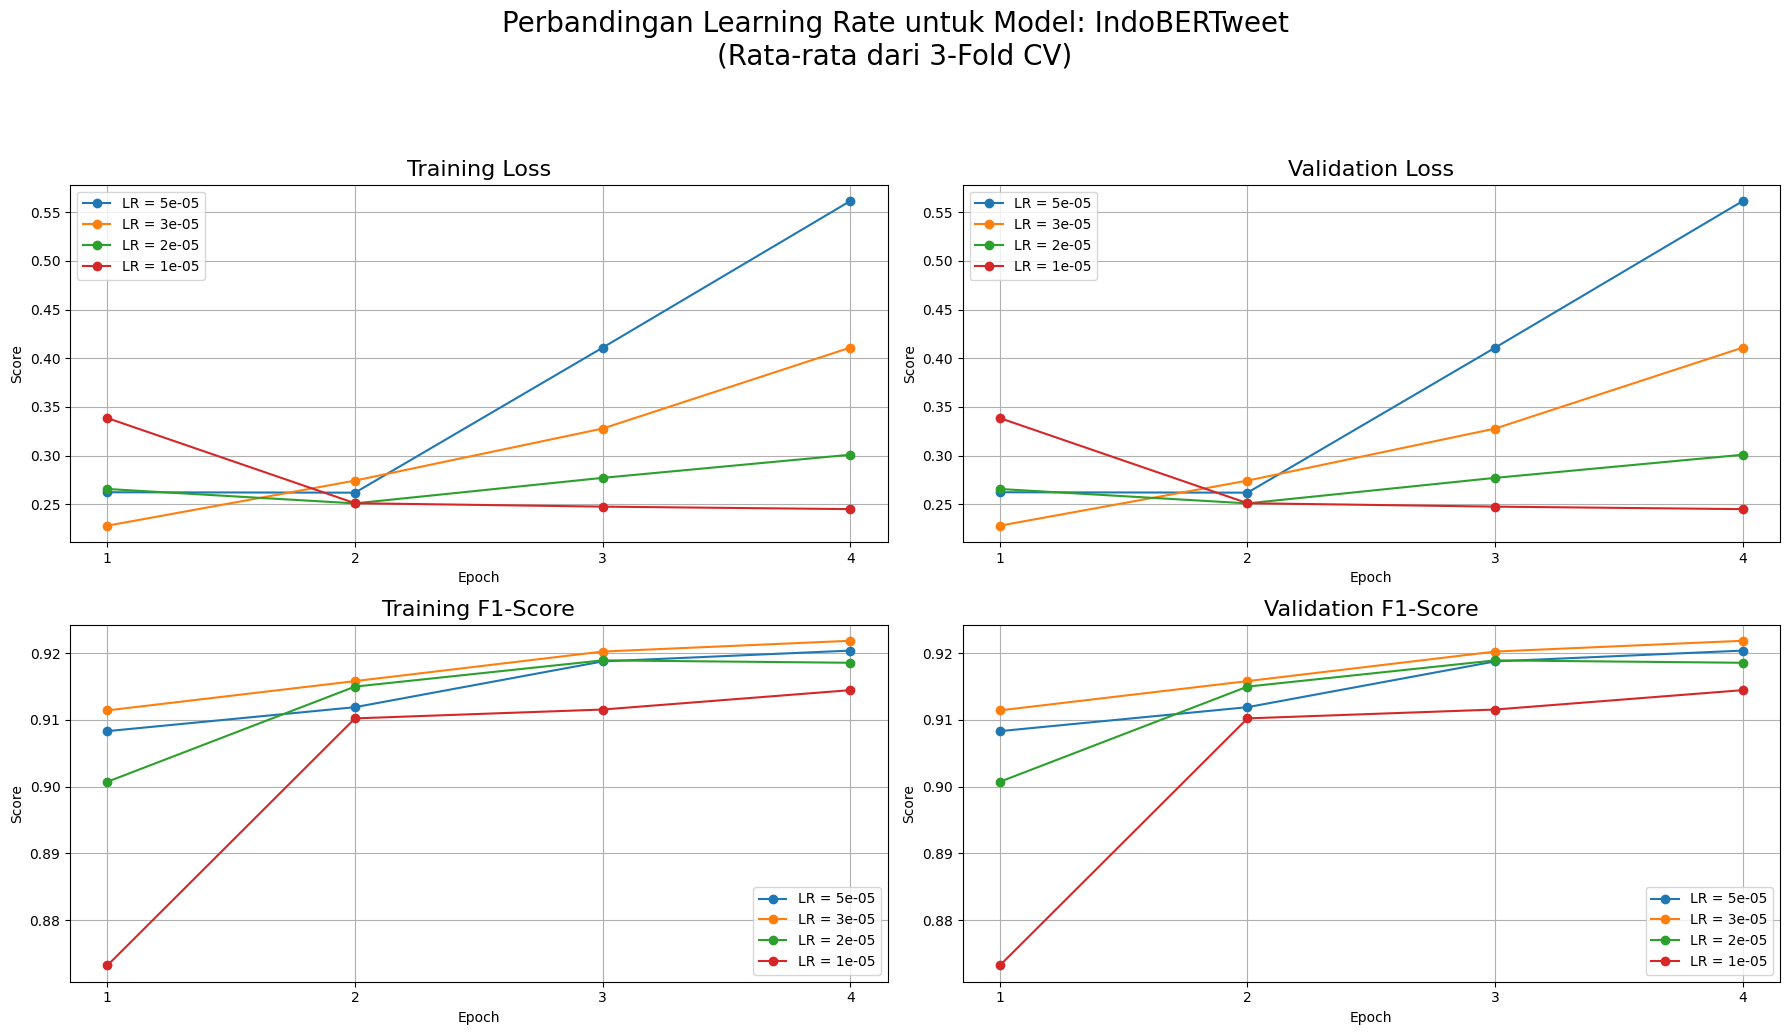

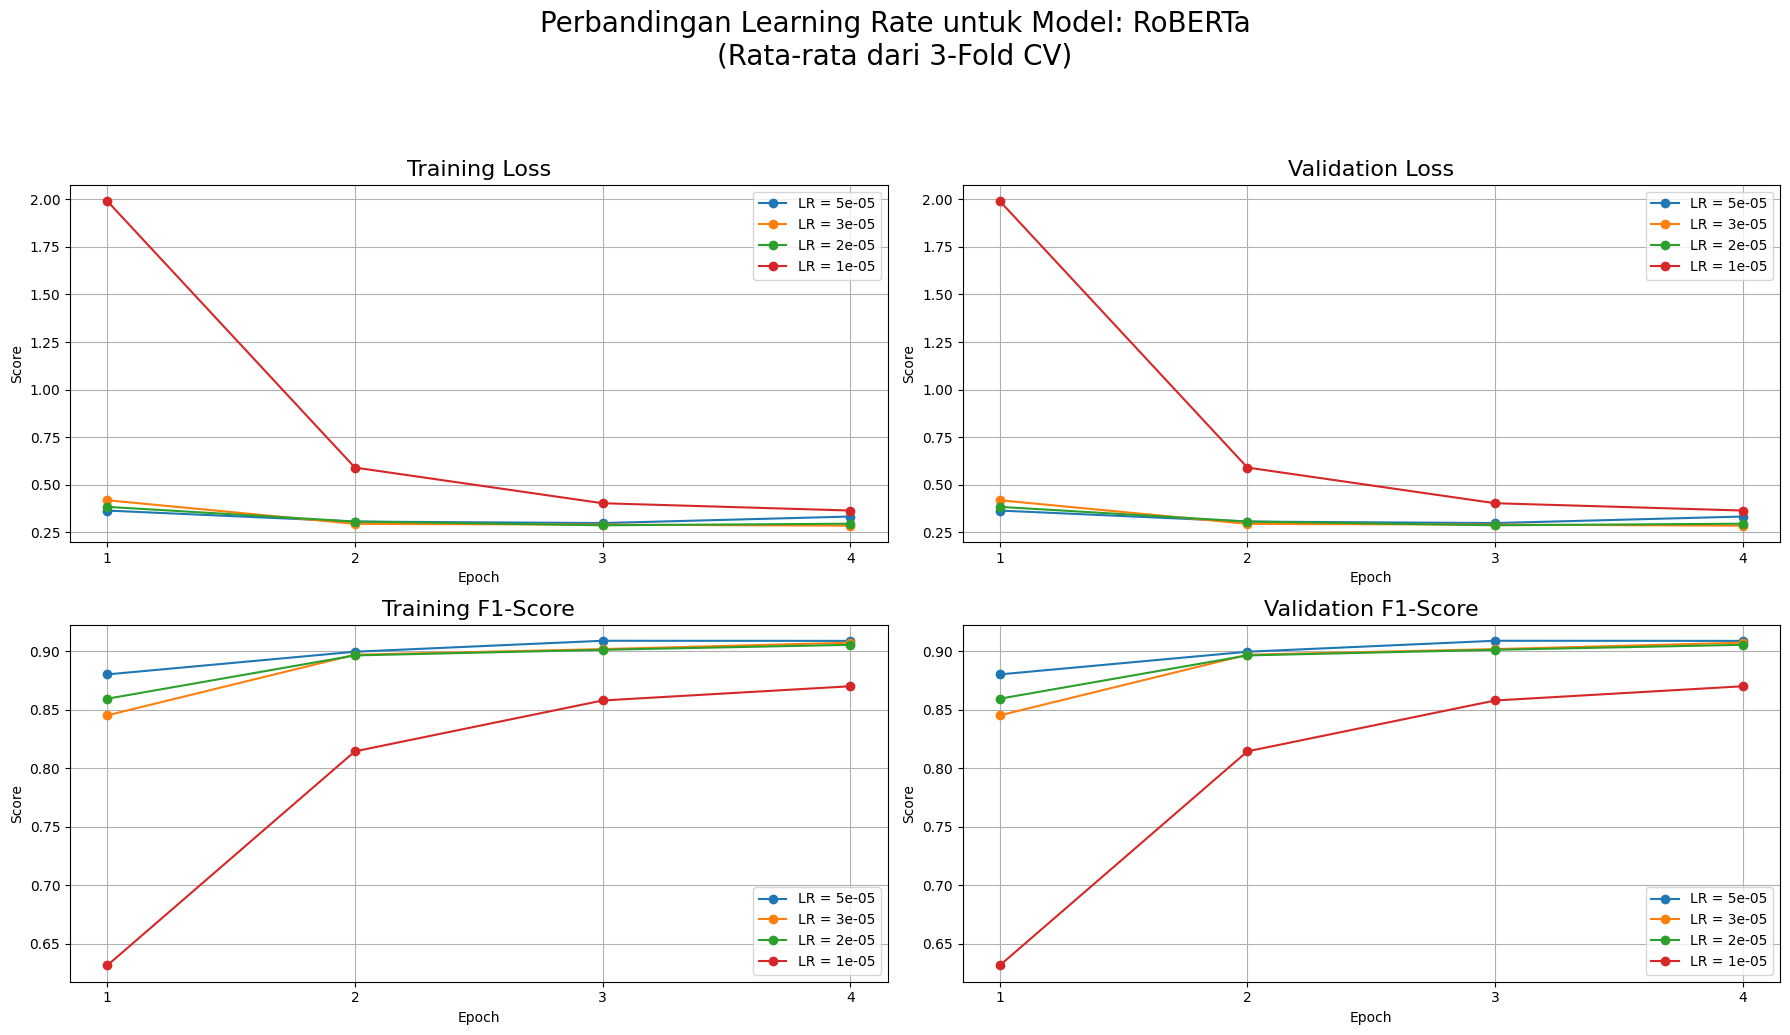

In [14]:
def plot_lr_comparison(model_name, lr_histories_dict):
    """Membuat plot perbandingan kurva belajar untuk berbagai LR pada satu model."""
    
    metrics_to_plot = ['loss', 'f1']
    metric_titles = ['Loss', 'F1-Score']
    
    fig, axes = plt.subplots(len(metrics_to_plot), 2, figsize=(18, len(metrics_to_plot) * 5))
    fig.suptitle(f'Perbandingan Learning Rate untuk Model: {model_name}\n(Rata-rata dari {N_SPLITS}-Fold CV)', fontsize=20, y=1.03)

    for i, metric in enumerate(metrics_to_plot):
        # Plot untuk Training
        ax_train = axes[i, 0]
        ax_train.set_title(f'Training {metric_titles[i]}', fontsize=16)
        # Plot untuk Validasi
        ax_val = axes[i, 1]
        ax_val.set_title(f'Validation {metric_titles[i]}', fontsize=16)

        for lr, history in lr_histories_dict.items():
            epochs_range = range(1, len(history[f'train_{metric}']) + 1)
            ax_train.plot(epochs_range, history[f'train_{metric}'], 'o-', label=f'LR = {lr}')
            ax_val.plot(epochs_range, history[f'val_{metric}'], 'o-', label=f'LR = {lr}')

        ax_train.set_xlabel('Epoch'); ax_train.set_ylabel('Score'); ax_train.legend(); ax_train.grid(True)
        ax_val.set_xlabel('Epoch'); ax_val.set_ylabel('Score'); ax_val.legend(); ax_val.grid(True)
        ax_train.set_xticks(epochs_range); ax_val.set_xticks(epochs_range)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Buat plot untuk setiap model yang diuji
for model_alias, lr_histories in all_histories.items():
    plot_lr_comparison(model_alias, lr_histories)